<a href="https://colab.research.google.com/github/azzindani/00_Kaggle_Dataset/blob/main/Brain_Metastases_Segmentation_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 00 Import Modules

In [1]:
#!pip install -q pydicom
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.6 MB/s eta 0:00:00


In [2]:
import os
import json
import nibabel as nib
import matplotlib.pyplot as plt
#import pydicom
import numpy as np
import cv2
import subprocess
import itertools
import mediapy as media

from PIL import Image
from IPython.display import Audio, Video, HTML
from matplotlib.animation import FuncAnimation
from base64 import b64encode
from io import BytesIO
from zipfile import ZipFile

## 01 Download Dataset

In [3]:
url = 'https://www.kaggle.com/datasets/kapilesha/brainmetshare-nii'

url_path = url.split('datasets/')[1]
url_path

'kapilesha/brainmetshare-nii'

In [4]:
!kaggle datasets download -d {url_path}

Dataset URL: https://www.kaggle.com/datasets/kapilesha/brainmetshare-nii
License(s): MIT
100% 2.49G/2.50G [00:33<00:00, 141MB/s]
100% 2.50G/2.50G [00:33<00:00, 81.1MB/s]


## 02 Extract Dataset

In [5]:
os.listdir()

['.config', 'brainmetshare-nii.zip', 'sample_data']

In [6]:
zipfile = ZipFile(os.listdir()[1])
zipfile.extractall() #'''

## 03 Get File List

In [9]:
root_dir = '/content/'
n = 20

counter = 0

path_list = []

for dirpath, dirnames, filenames in os.walk(root_dir):
  for filename in filenames:
    path_list.append(dirpath + '/' + filename)

  counter += 1
  if counter >= n:
    break

#path_list

In [10]:
file_format = '.nii'
n = 5
file_paths = []

for root, dirs, files in os.walk(root_dir):
  for file in files:
    if file.endswith(file_format):
      file_paths.append(os.path.join(root, file))

    if len(file_paths) >= n:
      break
  if len(file_paths) >= n:
    break

file_paths

['/content/train/Mets_007/t1_pre.nii',
 '/content/train/Mets_007/flair.nii',
 '/content/train/Mets_007/seg.nii',
 '/content/train/Mets_007/t1_gd.nii',
 '/content/train/Mets_007/bravo.nii']

| Modality | Highlights / Use Cases                                      | Appearance Characteristics                   |
|----------|-------------------------------------------------------------|-----------------------------------------------|
| **T1 (T1-weighted imaging)**   | Anatomy, fat, gray/white matter differentiation              | CSF appears dark; gray/white matter is distinct. |
| **FLAIR (Fluid-Attenuated Inversion Recovery)**| Lesions, abnormalities near CSF (fluid suppression)          | CSF is dark; lesions appear bright.            |
| **SEG (Segmentation)**  | Tumor regions and sub-regions                                | Binary or labeled mask.                       |
| **T2 (T2-weighted imaging)**   | Fluid-filled regions like edema, CSF                         | Fluid appears bright.                         |
| **T1CE (T1 Contrast-Enhanced imaging)** | Active tumor regions (contrast-enhanced)                     | Tumor appears brighter due to contrast agent. |


| **Modality**   | **Best for Masking**                         | **Highlights**                               | **Use Cases**                                  | **When to Use**                                |
|----------------|---------------------------------------------|---------------------------------------------|-----------------------------------------------|-----------------------------------------------|
| **T1CE**       | Active tumor regions                        | Enhancing tumor regions with contrast agent | Tumor characterization and segmentation      | When focusing on **active tumor regions**      |
| **FLAIR**      | Edema and diffuse tumor regions             | Lesions, edema, and infiltrating tissues    | Identifying edema or diffuse abnormalities    | When segmentation includes **edema** or infiltrative areas |
| **T2**         | Edema and fluid-related abnormalities       | Fluid-filled regions like edema or cysts    | Analyzing extent of edema or cystic structures | When focusing on **edema** or fluid-related areas |
| **T1**         | Gross anatomical structures (less common)   | Gray/white matter differentiation           | General anatomy visualization                | When needing **anatomical context**            |

## 04 Segmentation Preview

In [11]:
mask_path = file_paths[2]
mask_path

'/content/train/Mets_007/seg.nii'

### 04.01 File Properties Preview

In [12]:
img = nib.load(mask_path)
img_data = img.get_fdata()

print('Image data shape:', img_data.shape)

header = img.header
print('Header information:', header)

Image data shape: (256, 256, 150)
Header information: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256 150   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.     0.9375 0.9375 1.     1.     1.     1.     1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y    

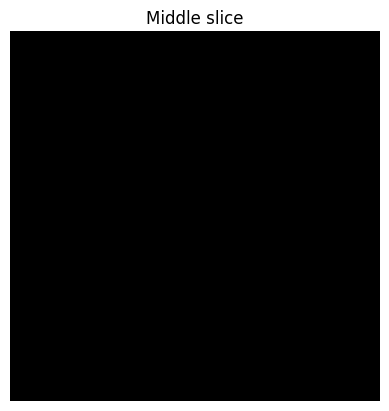

In [13]:
plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap = 'gray')
plt.title('Middle slice')
plt.axis('off')
plt.show()

### 04.02 Preview Multiple Images

Image data shape: (256, 256, 150)


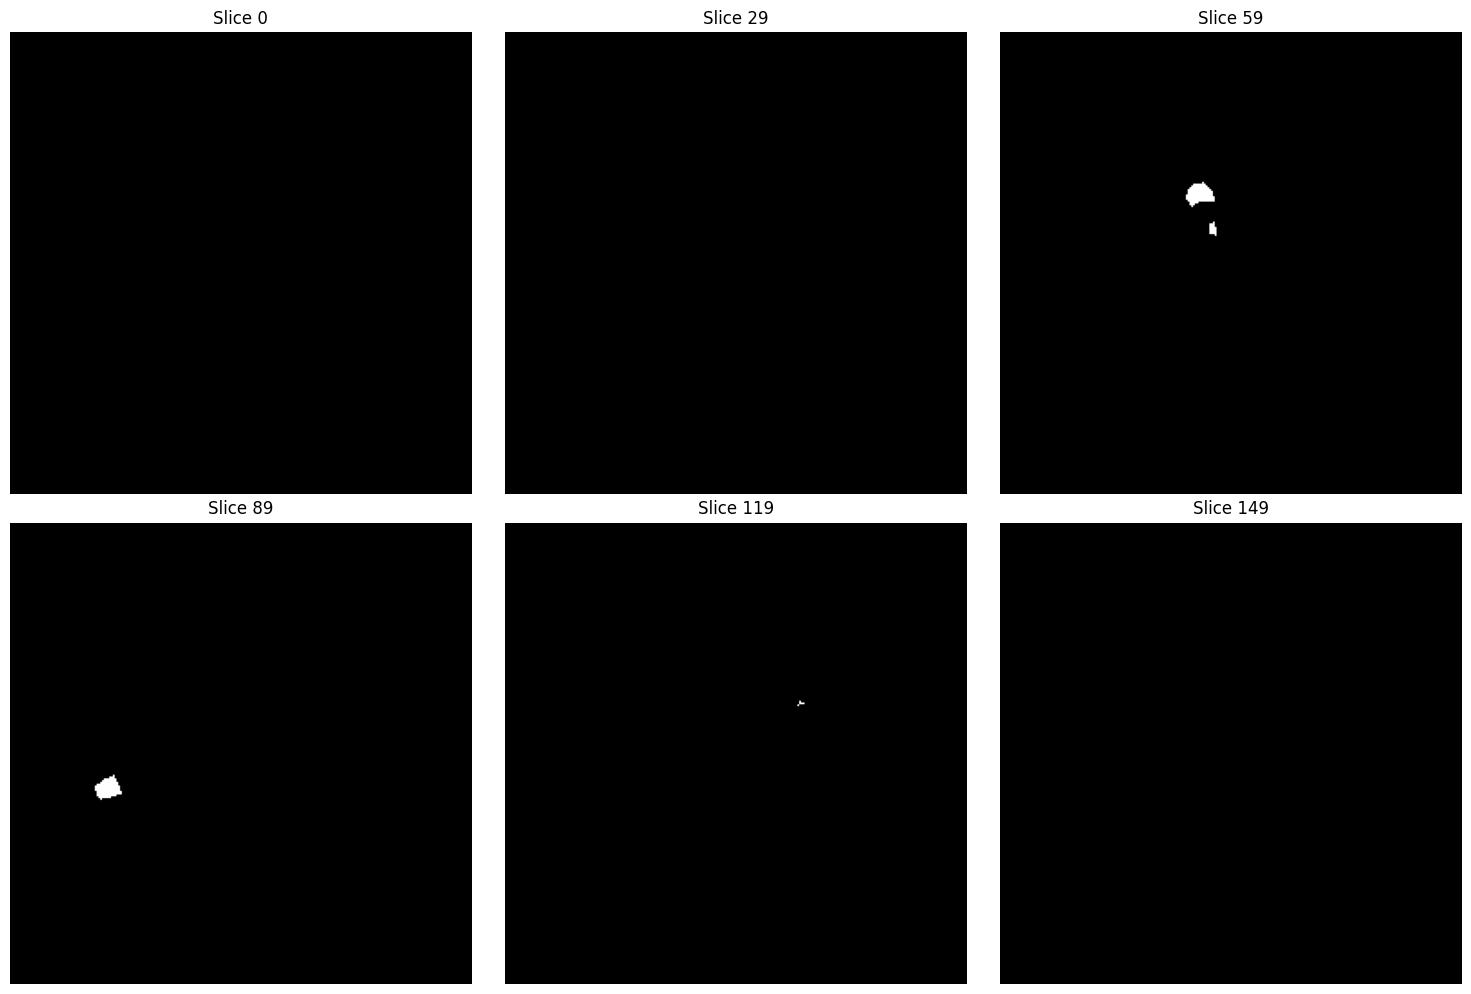

In [14]:
img = nib.load(mask_path)
img_data = img.get_fdata()

print('Image data shape:', img_data.shape)

num_slices = 6
slices = np.linspace(0, img_data.shape[2] - 1, num_slices).astype(int)

num_columns = 3
num_rows = (num_slices + num_columns - 1) // num_columns

plt.figure(figsize = (15, 5 * num_rows))

for i, slice_idx in enumerate(slices):
  plt.subplot(num_rows, num_columns, i + 1)
  plt.imshow(img_data[:, :, slice_idx], cmap = 'gray')
  plt.title(f'Slice {slice_idx}')
  plt.axis('off')

plt.tight_layout()
plt.show()

### 04.03 Preview Selected Image

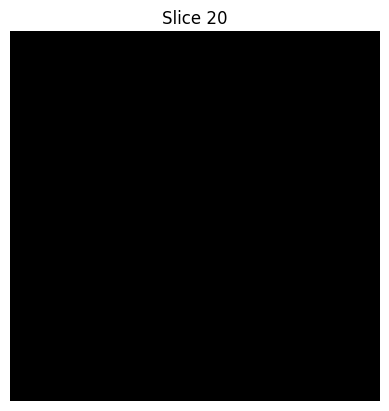

In [15]:
slice_idx = 20
plt.imshow(img_data[:, :, slice_idx], cmap = 'gray')
plt.title(f'Slice {slice_idx}')
plt.axis('off')
plt.show()

### 04.04 Preview as Video

In [16]:
img = nib.load(mask_path)
img_data = img.get_fdata()

height, width, n_frames = img_data.shape
print('Image data shape:', img_data.shape)

output_video = 'mask_video.mp4'
fps = 10

fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor = False)

for i in range(n_frames):
  frame = img_data[:, :, i]
  frame_normalized = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
  video_writer.write(frame_normalized)

video_writer.release()
print(f'Video saved as {output_video}')

Image data shape: (256, 256, 150)
Video saved as mask_video.mp4


Shape is (num_images, height, width, num_channels) = (150, 256, 256, 3).
Framerate is 10.0 frames/s.


""

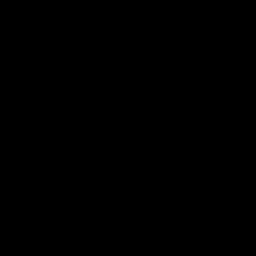

In [17]:
video = media.read_video(output_video)
print(f'Shape is (num_images, height, width, num_channels) = {video.shape}.')
if metadata := video.metadata:
  print(f'Framerate is {metadata.fps} frames/s.')
video2 = media.resize_video(video, tuple(np.array(video.shape[1:3]) // 1))
media.show_video(video2, fps = fps, codec = 'gif')

## 05 Original Preview

In [18]:
ori_path = file_paths[3]
ori_path

'/content/train/Mets_007/t1_gd.nii'

### 05.01 File Properties Preview

In [19]:
img = nib.load(ori_path)
img_data = img.get_fdata()

print('Image data shape:', img_data.shape)

header = img.header
print('Header information:', header)

Image data shape: (256, 256, 150)
Header information: <class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256 150   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : float32
bitpix          : 32
slice_start     : 0
pixdim          : [1.     0.9375 0.9375 1.     1.     1.     1.     1.    ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 0.0
qoffset_x       : 0.0
qoffset_y    

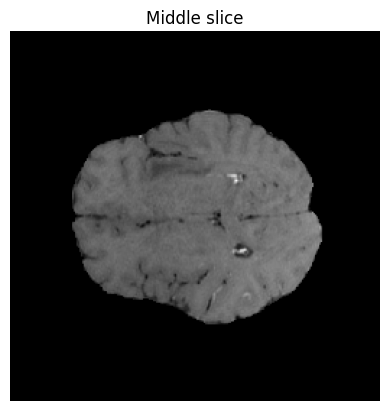

In [20]:
plt.imshow(img_data[:, :, img_data.shape[2] // 2], cmap = 'gray')
plt.title('Middle slice')
plt.axis('off')
plt.show()

### 05.02 Preview Multiple Images

Image data shape: (256, 256, 150)


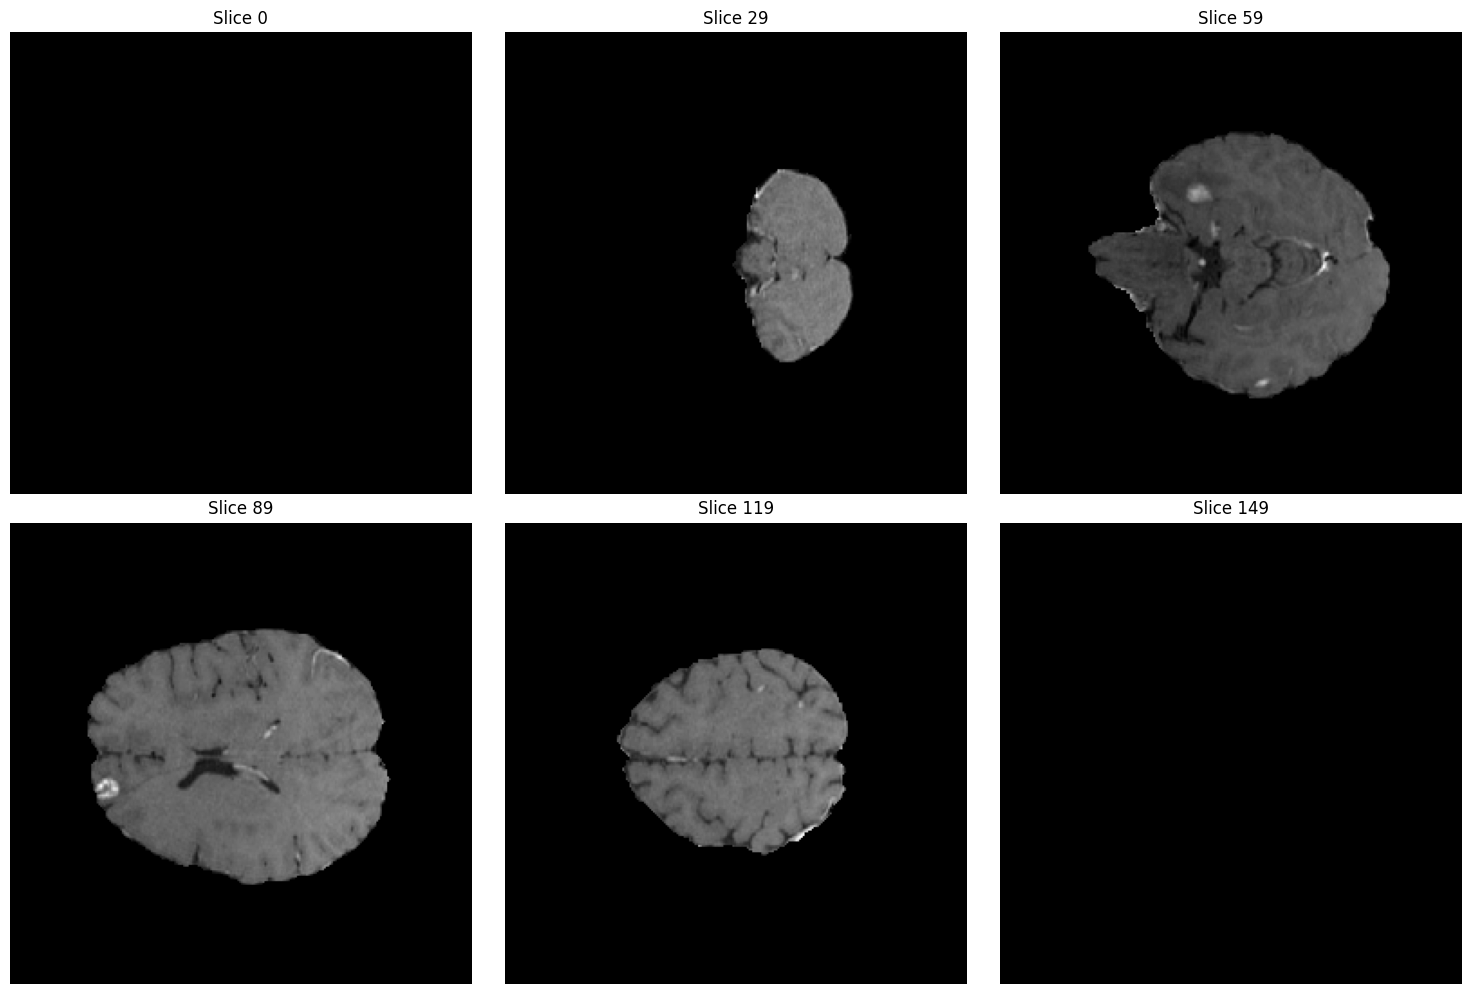

In [21]:
img = nib.load(ori_path)
img_data = img.get_fdata()

print('Image data shape:', img_data.shape)

num_slices = 6
slices = np.linspace(0, img_data.shape[2] - 1, num_slices).astype(int)

num_columns = 3
num_rows = (num_slices + num_columns - 1) // num_columns

plt.figure(figsize = (15, 5 * num_rows))

for i, slice_idx in enumerate(slices):
  plt.subplot(num_rows, num_columns, i + 1)
  plt.imshow(img_data[:, :, slice_idx], cmap = 'gray')
  plt.title(f'Slice {slice_idx}')
  plt.axis('off')

plt.tight_layout()
plt.show()

### 05.03 Preview Selected Image

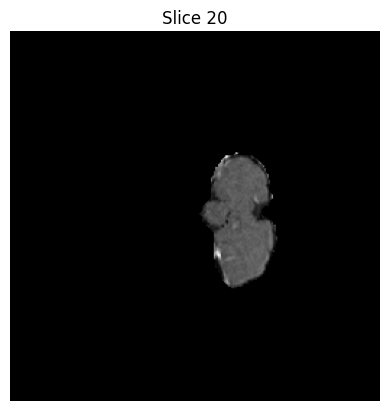

In [22]:
slice_idx = 20
plt.imshow(img_data[:, :, slice_idx], cmap = 'gray')
plt.title(f'Slice {slice_idx}')
plt.axis('off')
plt.show()

### 05.04 Preview as Video

In [23]:
img = nib.load(ori_path)
img_data = img.get_fdata()

height, width, n_frames = img_data.shape
print('Image data shape:', img_data.shape)

output_video = 'ori_video.mp4'
fps = 10

fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(output_video, fourcc, fps, (width, height), isColor = False)

for i in range(n_frames):
  frame = img_data[:, :, i]
  frame_normalized = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
  video_writer.write(frame_normalized)

video_writer.release()
print(f'Video saved as {output_video}')

Image data shape: (256, 256, 150)
Video saved as ori_video.mp4


Shape is (num_images, height, width, num_channels) = (150, 256, 256, 3).
Framerate is 10.0 frames/s.


""

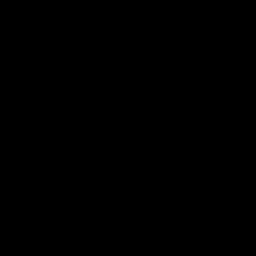

In [24]:
video = media.read_video(output_video)
print(f'Shape is (num_images, height, width, num_channels) = {video.shape}.')
if metadata := video.metadata:
  print(f'Framerate is {metadata.fps} frames/s.')
video2 = media.resize_video(video, tuple(np.array(video.shape[1:3]) // 1))
media.show_video(video2, fps = fps, codec = 'gif')

## 06 Masked Preview

In [25]:
ori_img = nib.load(ori_path)
mask_img = nib.load(mask_path)

ori_data = ori_img.get_fdata()
mask_data = mask_img.get_fdata()

ori_data = (ori_data - np.min(ori_data)) / (np.max(ori_data) - np.min(ori_data))

height, width = ori_data.shape[:2]
fps = 10
output_video_path = 'masked_video.mp4'
ori_opacity = 1
mask_opacity = 0.5

fourcc = cv2.VideoWriter_fourcc(*'XVID')
video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

for i in range(ori_data.shape[2]):
  ori_slice = (ori_data[:, :, i] * 255).astype(np.uint8)
  mask_slice = (mask_data[:, :, i] > 0).astype(np.uint8)

  color_mask = np.zeros((height, width, 3), dtype = np.uint8)
  color_mask[mask_slice == 1] = [255, 0, 0]

  ori_colored = cv2.cvtColor(ori_slice, cv2.COLOR_GRAY2BGR)
  combined_frame = cv2.addWeighted(ori_colored, ori_opacity, color_mask, mask_opacity, 0)
  video_writer.write(combined_frame)

video_writer.release()
print(f"Masked video saved to {output_video_path}")

Masked video saved to masked_video.mp4


Shape is (num_images, height, width, num_channels) = (150, 256, 256, 3).
Framerate is 10.0 frames/s.


""

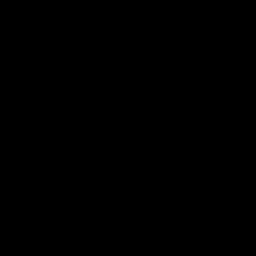

In [26]:
video = media.read_video(output_video_path)
print(f'Shape is (num_images, height, width, num_channels) = {video.shape}.')
if metadata := video.metadata:
  print(f'Framerate is {metadata.fps} frames/s.')
video2 = media.resize_video(video, tuple(np.array(video.shape[1:3]) // 1))
media.show_video(video2, fps = fps, codec = 'gif')